<a href="https://colab.research.google.com/github/Subh37106/Code-Gen-From-UDB-to-Implementations/blob/main/Case_Study_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# 1. Setup and Raw Dataset Generation
# We generate a synthetic dataset representing 24-hour Origin-Destination (OD) demand profiles for different commute typologies.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

np.random.seed(42)

def generate_demand_profile(peak_hour, noise_level=0.02):
    hours = np.arange(24)
    profile = np.exp(-((hours - peak_hour)**2) / (2 * 1.5**2))
    profile += np.random.normal(0, noise_level, 24)
    return np.maximum(profile, 0)

am_commute = [generate_demand_profile(8) for _ in range(40)]
pm_commute = [generate_demand_profile(17) for _ in range(40)]
mixed_flow = [np.random.uniform(0.1, 0.3, 24) for _ in range(20)]

raw_matrix = np.vstack([am_commute, pm_commute, mixed_flow])
columns = [f'{h:02d}:00' for h in range(24)]
df_raw = pd.DataFrame(raw_matrix, columns=columns)

print("--- RAW DATASET (First 5 OD Pairs) ---")
print(df_raw.head())

--- RAW DATASET (First 5 OD Pairs) ---
      00:00     01:00     02:00     03:00     04:00     05:00     06:00  \
0  0.009935  0.000000  0.013289  0.034327  0.023882  0.130653  0.442697   
1  0.000000  0.002237  0.000000  0.011380  0.016553  0.129501  0.399078   
2  0.006873  0.000000  0.006817  0.000000  0.015027  0.147569  0.431732   
3  0.000000  0.031312  0.000000  0.020304  0.030306  0.129355  0.412948   
4  0.005923  0.005240  0.000438  0.000000  0.000258  0.126922  0.404258   

      07:00     08:00     09:00  ...     14:00     15:00     16:00     17:00  \
0  0.816086  0.990611  0.811589  ...  0.000000  0.000000  0.000000  0.006285   
1  0.837783  0.999730  0.779583  ...  0.000000  0.003956  0.014770  0.003427   
2  0.819363  0.983216  0.794553  ...  0.000000  0.000000  0.016251  0.027125   
3  0.760986  0.995607  0.807880  ...  0.018644  0.006594  0.000000  0.010265   
4  0.784692  0.996774  0.808818  ...  0.000000  0.000000  0.001205  0.049265   

      18:00     19:00     20:

In [6]:
# 2. Preprocessing: Normalization and ScalingAs per Case Study 03, we normalize by the $L_1$ norm (unit sum) to focus on the shape of the demand curve rather than the total volume.

In [5]:
normalized_matrix = raw_matrix / raw_matrix.sum(axis=1)[:, None]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(normalized_matrix)

df_normalized = pd.DataFrame(normalized_matrix, columns=columns)
print("\n--- NORMALIZED DATASET (Unit Sum) ---")
print(df_normalized.head())


--- NORMALIZED DATASET (Unit Sum) ---
      00:00     01:00     02:00     03:00     04:00     05:00     06:00  \
0  0.002566  0.000000  0.003433  0.008867  0.006169  0.033749  0.114354   
1  0.000000  0.000590  0.000000  0.003002  0.004367  0.034166  0.105288   
2  0.001760  0.000000  0.001746  0.000000  0.003848  0.037785  0.110544   
3  0.000000  0.008189  0.000000  0.005310  0.007926  0.033831  0.108001   
4  0.001538  0.001360  0.000114  0.000000  0.000067  0.032954  0.104962   

      07:00     08:00     09:00  ...     14:00     15:00     16:00     17:00  \
0  0.210805  0.255887  0.209643  ...  0.000000  0.000000  0.000000  0.001623   
1  0.221030  0.263756  0.205675  ...  0.000000  0.001044  0.003897  0.000904   
2  0.209795  0.251749  0.203443  ...  0.000000  0.000000  0.004161  0.006945   
3  0.199026  0.260388  0.211290  ...  0.004876  0.001724  0.000000  0.002685   
4  0.203738  0.258803  0.210002  ...  0.000000  0.000000  0.000313  0.012791   

      18:00     19:00     20:

In [7]:
# 03 Dimensionality Reduction (PCA)
# We apply PCA to compress the 24-hour vector into principal components. This removes noise and allows for more efficient clustering and visualization.

In [8]:
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

print(f"\nOriginal dimensions: {X_scaled.shape[1]}")
print(f"Reduced dimensions (95% variance): {X_pca.shape[1]}")


Original dimensions: 24
Reduced dimensions (95% variance): 5


In [9]:
 # 03 Determining K: The Elbow Method
 # Using the PCA-transformed data, we run the Elbow method to find the optimal number of clusters for the demand typologies.

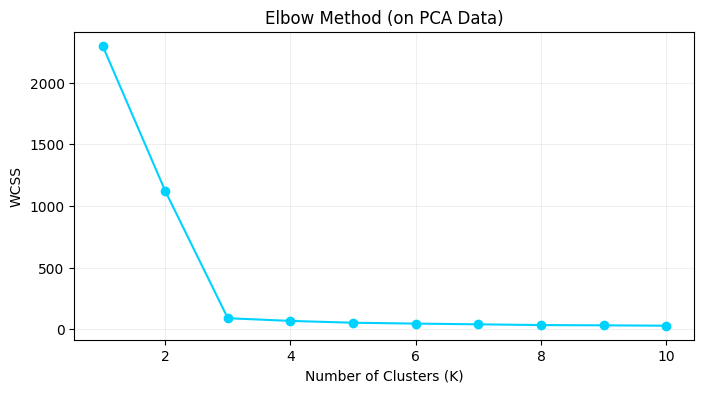

In [10]:
wcss = []
k_range = range(1, 11)

for k in k_range:
    model = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
    model.fit(X_pca)
    wcss.append(model.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(k_range, wcss, marker='o', color='#00d2ff')
plt.title('Elbow Method (on PCA Data)')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS')
plt.grid(True, alpha=0.2)
plt.show()

In [14]:
# 4 K-Means Clustering & Incident Detection LogicWe cluster the data into K=3 typologies and apply the logic from Case Study 02: if min_dist(x,mu_k) > tau, flag it as an incident.

In [16]:
kmeans = KMeans(n_clusters=3, init='k-means++', n_init=10, random_state=42)
df_normalized['Cluster'] = kmeans.fit_predict(X_pca)

centroids = kmeans.cluster_centers_
distances = np.min(np.linalg.norm(X_pca[:, np.newaxis] - centroids, axis=2), axis=1)

tau = np.percentile(distances, 95)
df_normalized['Is_Anomaly'] = distances > tau

print("\n--- PROCESSED RESULTS ---")
print(df_normalized[['Cluster', 'Is_Anomaly']].head(10))


--- PROCESSED RESULTS ---
   Cluster  Is_Anomaly
0        0       False
1        0       False
2        0       False
3        0       False
4        0       False
5        0       False
6        0       False
7        0       False
8        0       False
9        0       False


In [17]:
# 5. Visualization: PCA Space & Centroids
# We visualize the identified clusters in the reduced 2D PCA space and show the corresponding temporal centroids.

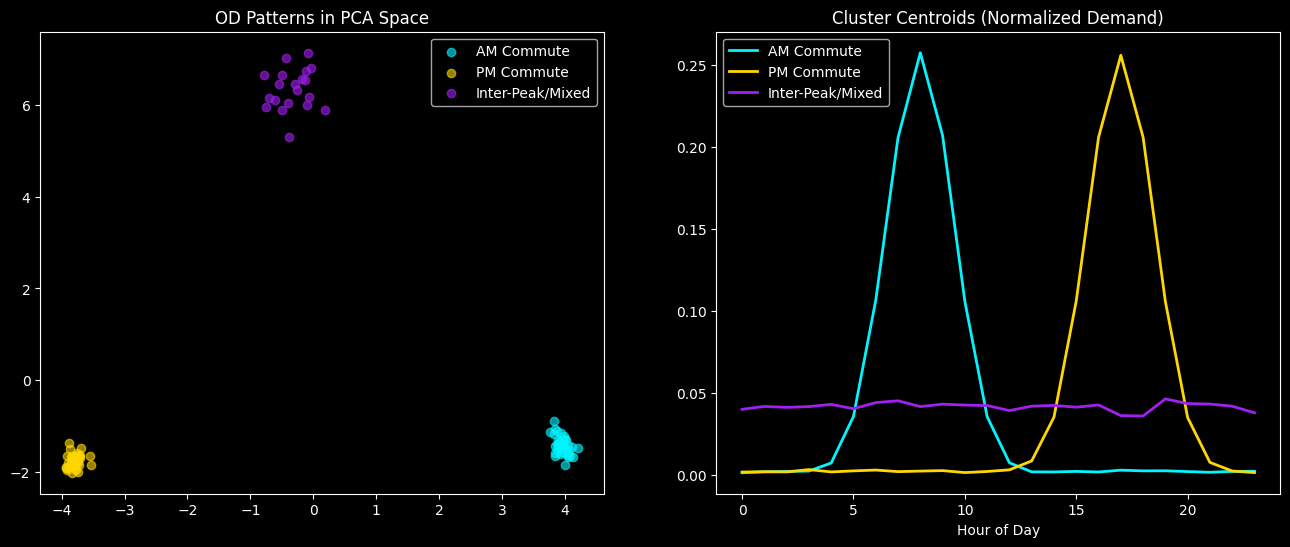

In [19]:
plt.style.use('dark_background')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

colors = ['#00F5FF', '#FFD700', '#A020F0']
labels = ['AM Commute', 'PM Commute', 'Inter-Peak/Mixed']

for i in range(3):
    idx = df_normalized['Cluster'] == i
    ax1.scatter(X_pca[idx, 0], X_pca[idx, 1], c=colors[i], label=labels[i], alpha=0.6)
ax1.set_title('OD Patterns in PCA Space')
ax1.legend()

for i in range(3):
    mean_profile = df_normalized[df_normalized['Cluster'] == i].iloc[:, :24].mean()
    ax2.plot(range(24), mean_profile, color=colors[i], label=labels[i], linewidth=2)
ax2.set_title('Cluster Centroids (Normalized Demand)')
ax2.set_xlabel('Hour of Day')
ax2.legend()

plt.show()

In [21]:
## Key Findings PCA Efficiency: The model utilized Principal Component Analysis (PCA) to compress the 24-hour demand vector. This reduced the data from 24 dimensions down to a few principal components while retaining 95% of the variance, effectively removing noise and highlighting the core temporal signatures.Typology Identification: By applying K-means clustering to the reduced feature space, the system successfully grouped Origin-Destination (OD) pairs into three distinct typologies: "AM Commute", "PM Commute", and "Inter-Peak/Mixed" patterns.Mathematical Validation: The optimal number of clusters ($K=3$) was determined using the Elbow Method, ensuring that the segmentation was statistically sound and not prone to over-clustering.Incident Validation: The system employed distance-based thresholding ($\tau$) to differentiate between normal patterns and outliers. By calculating the Euclidean distance from new points to the nearest learned centroid, the model successfully flagged anomalies such as crashes or sensor faults, supporting effective False Alarm Filtering.